In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%qtconsole

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from src.simulation import load_simulated_spikes_with_real_position

(position, spikes, is_training,
 place_field_centers, position_info) = load_simulated_spikes_with_real_position()

/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
from replay_trajectory_classification import SortedSpikesClassifier
from src.parameters import SAMPLING_FREQUENCY

classifier = SortedSpikesClassifier(
        movement_var=np.sqrt(15/SAMPLING_FREQUENCY), replay_speed=130,
        continuous_transition_types=['empirical_movement', 'uniform', 'identity']).fit(
    position, spikes, is_training=is_training)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


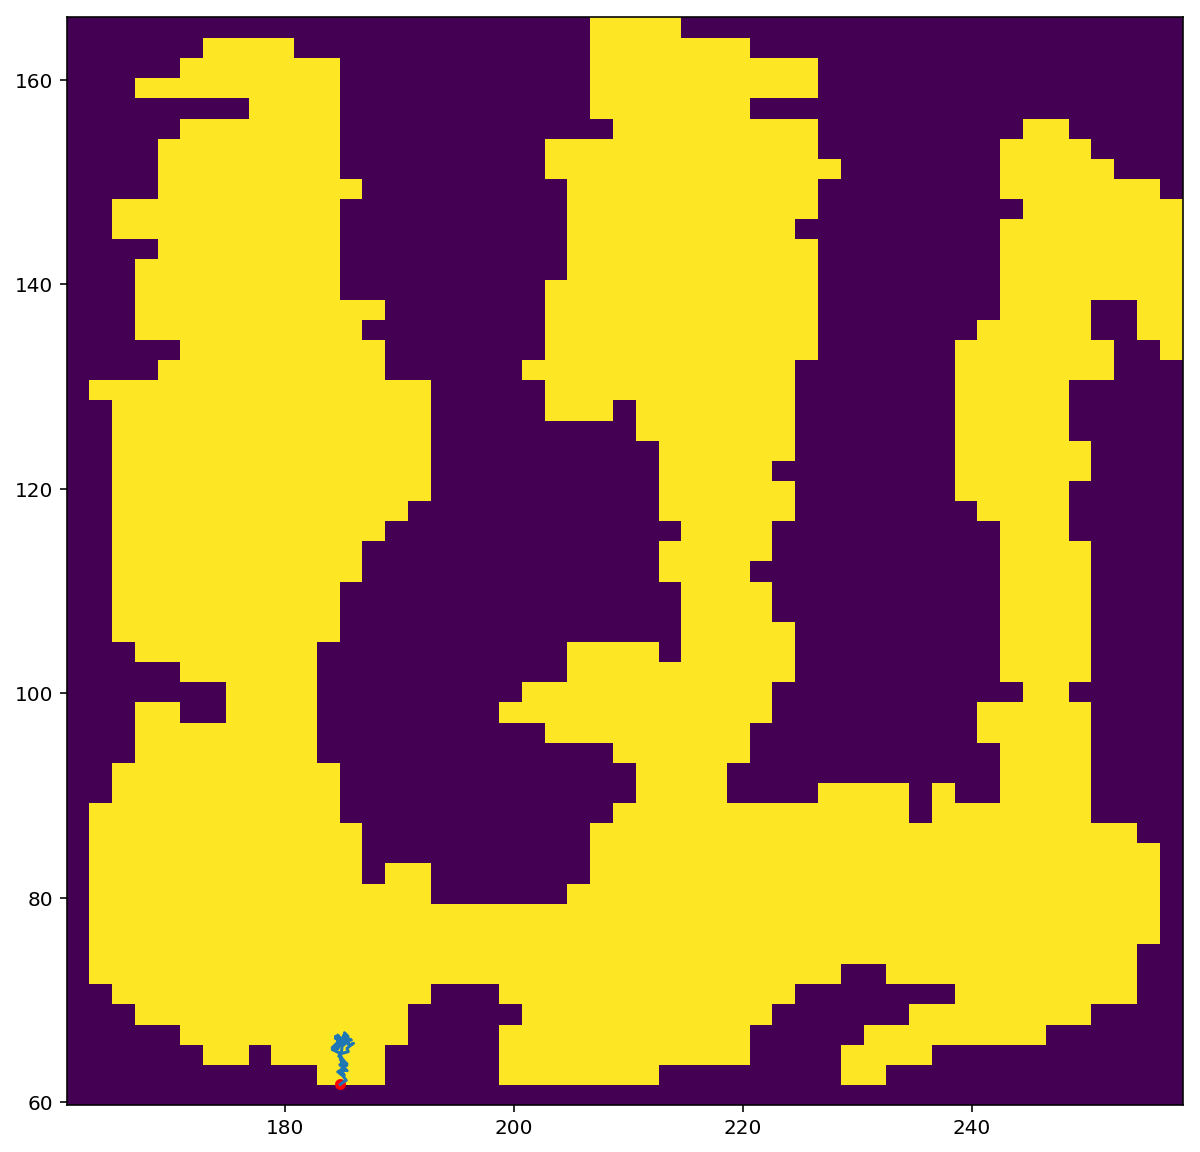

In [95]:
from scipy.stats import multivariate_normal

centers = [dim_edges[:-1] + np.diff(dim_edges) / 2
           for dim_edges in classifier.edges_]
x, y = np.meshgrid(centers[0], centers[1])

plt.figure(figsize=(10,10))
plt.pcolormesh(x, y, classifier.is_track_interior_.T);

track_bin_centers = classifier.place_bin_centers_[classifier.is_track_interior_.ravel(order='F')]
start_bin = track_bin_centers[1]

plt.scatter(start_bin[0], start_bin[1], color='red', s=20)

gaussian = multivariate_normal(mean=[0.0, 0.0], cov=np.sqrt(15/SAMPLING_FREQUENCY))

n_time_steps = 80
n_samples = 1000

loc = np.zeros((n_time_steps, 2))
loc[0] = start_bin.copy()

for i in np.arange(1, n_time_steps):
    loc[i] = loc[i-1] + gaussian.rvs()

plt.plot(loc[:, 0], loc[:, 1], zorder=10)

## Steps

1. Simulate next position
2. Get velocity vector from last position
3. Check nearby boundaries if it has crossed
4. If it hits the boundary then reflect
5. Else continue

In [ ]:
def random_walk3(position, edges, place_bin_centers, movement_var,
                 is_track_interior, replay_speed=20):
    '''Zero mean random walk with movement_var.

    This version assumes the bin size is too big to propertly capture the
    small gaussian. So we sample a finer grid with constraints and then
    speed it up. Finally we rebin to the larger bin size and average.
    The downside to this method is that it takes up a lot of memory.

    Parameters
    ----------
    place_bin_centers : ndarray, shape (n_bins, n_position_dims)
    movement_var : float,
    is_track_interior : bool ndarray, shape (n_x_bins, n_y_bins)
    replay_speed : int

    Returns
    -------
    transition_matrix : ndarray, shape (n_bins, n_bins)

    '''
    _, _, finer_place_bin_centers, _ = get_grid(
        position, bin_size=movement_var**2, position_range=None)

    transition_matrix = random_walk(finer_place_bin_centers, movement_var,
                                    is_track_interior, replay_speed)

    H, _ = np.histogramdd(finer_place_bin_centers, bins=edges)

## Verify Random Walk

In [8]:
from replay_trajectory_classification import SortedSpikesClassifier

x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

x, y = np.meshgrid(x, y)
pos = np.stack((x.ravel(), y.ravel()), axis=1)

classifier_rw1 = SortedSpikesClassifier(place_bin_size=2.0, movement_var=1.0,
                                        continuous_transition_types=['random_walk'])
classifier_rw1.fit_place_grid(pos)
classifier_rw1.fit_continuous_state_transition(
    pos, None, is_track_interior=None,
    continuous_transition_types=classifier_rw1.continuous_transition_types,
    infer_track_interior=False)


classifier_rw2 = SortedSpikesClassifier(place_bin_size=2.0, movement_var=1.0,
                                    continuous_transition_types=['random_walk2'])
classifier_rw2.fit_place_grid(pos)
classifier_rw2.fit_continuous_state_transition(
    pos, None, is_track_interior=None,
    continuous_transition_types=classifier_rw2.continuous_transition_types,
    infer_track_interior=False)

INFO:replay_trajectory_classification.classifier:Fitting state transition...


IndexError: boolean index did not match indexed array along dimension 0; dimension is 144 but corresponding boolean dimension is 169